In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
import pandas as pd
mp.mp.dps = 30 #higher precision
import csv
import json
from PyMatching import *
import os

In [2]:
#pymatching to compare to
num_shots = 1000
Ls = [4,6]
ps = np.linspace(0.01, 0.15, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [3]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

In [30]:
import re

def read_results_file_without_comma_seperation(path):
    with open(path, 'r') as file:
        content = file.read()

    # Add a comma between each dictionary block
    content = content.strip()
    content = content.replace('}\n{', '},\n{')

    # Wrap the content in square brackets to make it a valid JSON array
    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        return None

    return data

def read_results_file_pure_bitflip(path):

    with open(path, 'r') as file:
        content = file.read()

    content = content.strip().rstrip(',')

    corrected_json = f'[{content}]'

    try:
        data = json.loads(corrected_json)
    except json.JSONDecodeError as e:
        raise RuntimeError(f"Failed to parse JSON: {e}")


    return data

def parse_file(filename):
    data = []
    try:
        with open(filename, 'r') as file:
            content = file.read()
            # print("file content printout (for debugging):")
            # print(content)
    except FileNotFoundError:
        return

    # Split content into individual blocks
    blocks = content.split('}\n{')  # Assuming blocks are separated by double newlines

    for block in blocks:
        # Extract histogram_seed, run_seed, and results
        histogram_seed_match = re.search(r'"histogram_seed": "(\d+)"', block)
        run_seed_match = re.search(r'"run_seed": "(\d+)"', block)
        results_match = re.search(r'"results": \[([^]]*)\]', block)

        if histogram_seed_match and run_seed_match and results_match:
            histogram_seed = histogram_seed_match.group(1)
            run_seed = run_seed_match.group(1)
            results_str = results_match.group(1)

            # Process results
            results = {}
            results_items = results_str.split(',')
            for item in results_items:
                key_value = item.split(':')
                if len(key_value) == 2:
                    key = key_value[0].strip().strip('"')
                    value = float(key_value[1].strip())
                    results[key] = value

            data.append({
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "results": results
            })

    return data

def process_data(data, batch_results, p, size, error):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        batch_results.append({
                'prob': p,
                'size': size,
                'error': error,
                'histogram_seed': histogram_seed,
                'run_seed': run_seed,
                'E': E_list,
                'log_g': log_g_list
            })
        # offset = log_sum_exp(log_g_list)
        # print('deviation from sqrt(2)xy: ', mp.log(2)*size*size - offset, ' log sum exp:', offset)

def rescale_log_g(log_g_list, size):
    offset = log_sum_exp(log_g_list)
    rescaled_log_g_list = [res + mp.log(2) * size * size - offset for res in log_g_list]
    return rescaled_log_g_list


def check_condition(group):
    if len(group) != 4:
        return pd.Series({'There are still error classes missing': None})
    f_0000 = group.loc[group['error'] == '0000', 'free_energy'].values[0]

    f_others = group.loc[group['error'].isin(['0100', '1000', '1100']), 'free_energy']

    return pd.Series({'success': int(f_0000 < f_others.min())})

In [5]:

# Eight Vertex limit read
batch_results = []
probabilities = [0.11, 0.12, 0.13]
sizes = [4, 6]
intervals = [10, 16]
iterations = 1000
overlap = 0.25
walkers = 4
alpha = 0.8
beta = 1e-8
exchange = 10

batch_results = []

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in ["0000", "0100", "1000", "1100"]:
                filename = f"../results/eight_vertex/bit_flip_limit/prob_x_{p:.6f}/prob_y_0.000100/prob_z_0.000100/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram__intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset_{exchange}.txt"
                if os.path.exists(filename):
                    try:
                        data = read_results_file_pure_bitflip(filename)
                        if data:
                            process_data(data, batch_results, p, size, error)
                    except:
                        data = read_results_file_without_comma_seperation(filename)
                        if data:
                            process_data(data, batch_results, p, size, error)
print("eight vertex limit results: ", len(batch_results))


eight vertex limit results:  143918


In [28]:
# pure bitflip wl read
walkers = 8
exchange = 20

batch_results_pure_bitflip = []

for interval in intervals:
    for p in probabilities:
        for size in sizes:
            for error in ["I", "X", "Y", "Z"]:
                filename = f"../results/periodic/prob_{p:.6f}/X_{size}_Y_{size}/error_class_{error}/StitchedHistogram_intervals_{interval}_iterations_{iterations}_overlap_{overlap:.6f}_walkers_{walkers}_alpha_{alpha:.6f}_beta_{beta:.10f}_exchange_offset{exchange}.txt"
                if os.path.exists(filename):
                    try:
                        data = read_results_file_pure_bitflip(filename)
                        if data:
                            process_data(data, batch_results_pure_bitflip, p, size, error)
                    except:
                        print(f"no file {filename}")
print("pure bit flip results: ", len(batch_results_pure_bitflip))

pure bit flip results:  168000


In [7]:
# Get free energies
batch_with_free_energy = []

T_Nish = 1/(mp.log((1-p)/p)/2)
T = T_Nish

# Loop through each list in batch_results
for result in batch_results:
    E_list = result['E']

    rescaled_log_g_list = rescale_log_g(result['log_g'], result['size']) # log(2)xy rescaling

    # Compute the free energy
    free_energy_value = free_energy(E_list, rescaled_log_g_list, T) # -T as prefactor

    # Add the computed free energy to the dictionary
    result['free_energy'] = free_energy_value
    result['rescaled_log_g'] = rescaled_log_g_list

    # Add the updated dictionary to the list for DataFrame creation
    batch_with_free_energy.append(result)

# Create a DataFrame from the list of updated dictionaries
batch_df = pd.DataFrame(batch_with_free_energy)


In [38]:
# Get free energies pure bitflip code
batch_with_free_energy_pure_bitflip = []

T_Nish = 1/(mp.log((1-p)/p)/2)
T = T_Nish


for result in batch_results_pure_bitflip:
    E_list = result['E']

    rescaled_log_g_list = rescale_log_g(result['log_g'], result['size']) # log(2)xy rescaling

    # Compute the free energy
    free_energy_value = free_energy(E_list, rescaled_log_g_list, T) # -T as prefactor

    # Add the computed free energy to the dictionary
    result['free_energy'] = free_energy_value
    result['rescaled_log_g'] = rescaled_log_g_list

    # Add the updated dictionary to the list for DataFrame creation
    batch_with_free_energy_pure_bitflip.append(result)

# Create a DataFrame from the list of updated dictionaries
batch_df_pure_bitflip = pd.DataFrame(batch_with_free_energy_pure_bitflip)

In [34]:
grouped = batch_df.groupby(['prob', 'size', 'histogram_seed'])
filtered_groups = grouped.filter(lambda g: len(g)==4)
filtered_groups = filtered_groups.reset_index(drop=True)
grouped_for_logical_failures_df = filtered_groups.groupby(['prob', 'size', 'histogram_seed'])
success_df = grouped_for_logical_failures_df.apply(check_condition).reset_index()
logical_failure_rate_df = (
    success_df.groupby(['prob', 'size'])
    .agg(
        success_sum=('success', 'sum'),
        count=('success', 'size')
    )
    .reset_index()
)

# Calculate logical failure rate
logical_failure_rate_df['logical_failure_rate'] = 1 - (logical_failure_rate_df['success_sum'] / logical_failure_rate_df['count'])

print(logical_failure_rate_df)

   prob  size  success_sum  count  logical_failure_rate
0  0.11     4         4232   5971              0.291241
1  0.11     6         4607   6000              0.232167
2  0.12     4         4053   5974              0.321560
3  0.12     6         4345   6000              0.275833
4  0.13     4         3750   5973              0.372175
5  0.13     6         4030   6000              0.328333


/tmp/ipykernel_1263436/1371673229.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_df = grouped_for_logical_failures_df.apply(check_condition).reset_index()


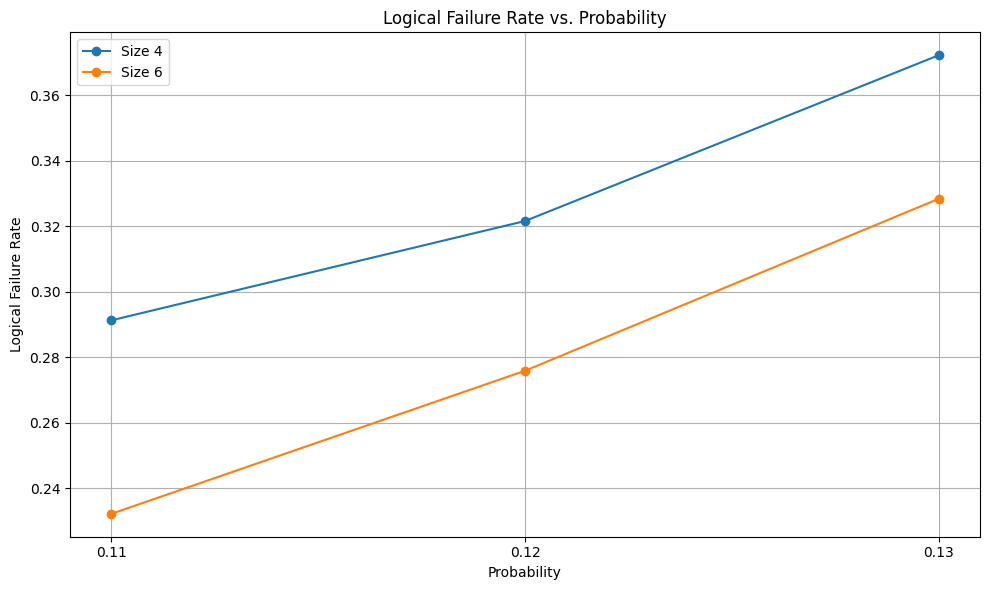

In [35]:
plt.figure(figsize=(10, 6))

# Loop through sizes to plot each one
for size in logical_failure_rate_df['size'].unique():
    subset = logical_failure_rate_df[logical_failure_rate_df['size'] == size]
    plt.plot(subset['prob'], subset['logical_failure_rate'], marker='o', label=f'Size {size}')

plt.title('Logical Failure Rate vs. Probability')
plt.xlabel('Probability')
plt.ylabel('Logical Failure Rate')
plt.legend()
plt.grid(True)
plt.xticks(logical_failure_rate_df['prob'].unique())  # Set x-ticks to the unique probabilities
plt.tight_layout()
plt.show()

Here is comparison of raw data between eight vertex and pure bitflip implementation

In [41]:
batch_df_aggregated = batch_df
batch_df_aggregated['free_energy'] = batch_df_aggregated['free_energy'].astype(float)
batch_df_aggregated = batch_df_aggregated.groupby(['prob', 'size', 'error'])['free_energy'].agg(['mean', 'var']).reset_index()
display(batch_df_aggregated)

,prob,size,error,mean,var
0,0.11,4,0000,-27.071603,4.905154
1,0.11,4,0100,-24.955131,2.198202
2,0.11,4,1000,-25.178935,1.723301
3,0.11,4,1100,-24.004975,1.163884
4,0.11,6,0000,-60.352249,10.323026
5,0.11,6,0100,-57.139008,5.576251
6,0.11,6,1000,-58.330355,4.323561
7,0.11,6,1100,-55.990382,2.880805
8,0.12,4,0000,-26.732569,4.734333
9,0.12,4,0100,-24.850701,2.124265


In [40]:

batch_df_pure_bitflip['free_energy'] = batch_df_pure_bitflip['free_energy'].astype(float)
batch_df_pure_bitflip_aggregated = batch_df_pure_bitflip.groupby(['prob', 'size', 'error'])['free_energy'].agg(['mean', 'var']).reset_index()
display(batch_df_pure_bitflip_aggregated)

Here is old result handling with dict list

In [18]:
from collections import defaultdict

# only keep results which come with all different error types:
#Changing structure to match postprocessing and plotting

# grouped dictionary with keys prob size and hist seed
grouped_results = defaultdict(list)
for result in batch_results:
    key = (result['prob'], result['size'], result['histogram_seed'])
    grouped_results[key].append(result)

In [19]:
filtered_results = defaultdict(list)
for key, results in grouped_results.items():
    newkey = (key[0],key[1])
    errors = set(result['error'] for result in results)
    if errors == {"0000", "0100", "1000", "1100"}:
        # To be removed once normalization is properly handled in c
        for result in results:
            log_g_list = result['log_g']
            offset = log_sum_exp(log_g_list)
            rescaled_log_g_list = [res + mp.log(2)*key[1]*key[1] - offset for res in log_g_list]
            result['log_g'] = rescaled_log_g_list
        filtered_results[newkey].append([[result['E'], result['log_g']] for result in results])
    else:
        print(f"has issue with an error class prob: {key[0]} size: {key[1]} interaction seed: {key[2]} available errors: {errors}")

has issue with an error class prob: 0.11 size: 4 interaction seed: 4883 available errors: {'1100', '0100', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 7306 available errors: {'1100', '1000', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 6227 available errors: {'1100', '0100', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 4424 available errors: {'1100', '1000', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 5289 available errors: {'1100', '1000', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 5669 available errors: {'1100', '0100', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 4737 available errors: {'1100', '0100', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 5694 available errors: {'1100', '1000', '0000'}
has issue with an error class prob: 0.11 size: 4 interaction seed: 3450 availabl

In [20]:
free_energies_batch = []
for p in probabilities:
    T_Nish = 1/(mp.log((1-p)/p)/2)
    temperatures = [1e-15,T_Nish,1e15]
    free_energies_size = []
    for size in sizes:
        batch_res = filtered_results[(p,size)]
        free_energies = get_free_energies(batch_res,temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds at p',p,', size',size,':', len(free_energies))
    free_energies_batch.append(free_energies_size)

Number of seeds at p 0.11 , size 4 : 5971
Number of seeds at p 0.11 , size 6 : 6000
Number of seeds at p 0.12 , size 4 : 5974
Number of seeds at p 0.12 , size 6 : 6000
Number of seeds at p 0.13 , size 4 : 5973
Number of seeds at p 0.13 , size 6 : 6000


In [22]:
import scipy

optimal_curves = []
T0_curves = []

lower_bounds_T0 = []
upper_bounds_T0 = []

for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    lower_bound_T0 = []
    upper_bound_T0 = []
    for j in range(len(sizes)):

       free_energies = free_energies_batch[i][j]

       if len(free_energies) == 0:
              continue

       #TO CHECK: if there is ever any significant difference between <= and < here
       #if so, should take degeneracy into account, and count with fraction if <=
       #Seems not to be an issue though
       temp = 1 #Nishimori temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       optimal_curve.append(res)

       temp = 0 #Low temp
       res =  1 - mp.fsum([f_class[0][temp] < f_class[1][temp]\
              or f_class[0][temp] < f_class[2][temp]\
              or f_class[0][temp] < f_class[3][temp] for f_class in free_energies])/(len(free_energies))
       T0_curve.append(res)

       number_success = round(len(free_energies) * res)
       number_failure = len(free_energies) - number_success

       lower_bound_T0.append(res-scipy.stats.beta.ppf(0.025, 0.5 + number_success, 0.5 + number_failure))
       upper_bound_T0.append(scipy.stats.beta.ppf(0.975, 0.5 + number_success, 0.5 + number_failure)-res)

    lower_bounds_T0.append(lower_bound_T0)
    upper_bounds_T0.append(upper_bound_T0)
    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

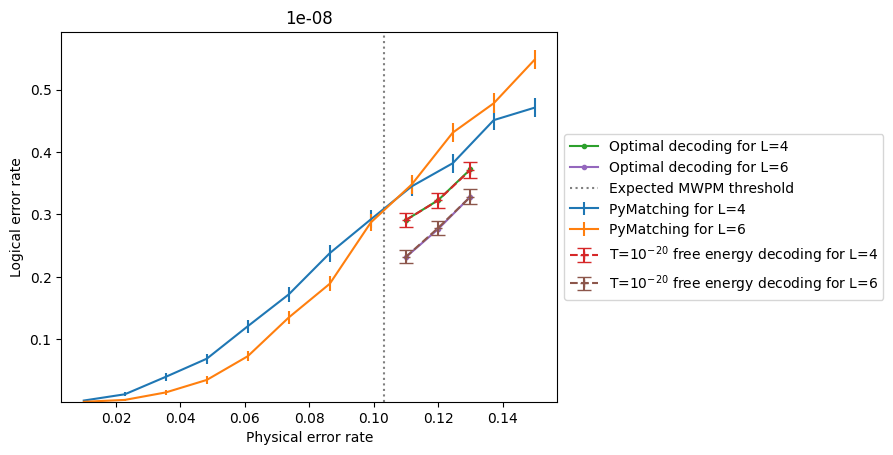

In [23]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))


for i, size in enumerate(sizes):
    plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
    # plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)
    plt.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities))],
                 yerr=[[ upper_bounds_T0[j][i]  for j in range(len(probabilities))], [lower_bounds_T0[j][i] for j in range(len(probabilities))]],
                 fmt='+--', label=r"T=$10^{-20}$ free energy decoding for L=%d" % size, capsize=5)


plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)
plt.title(beta)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

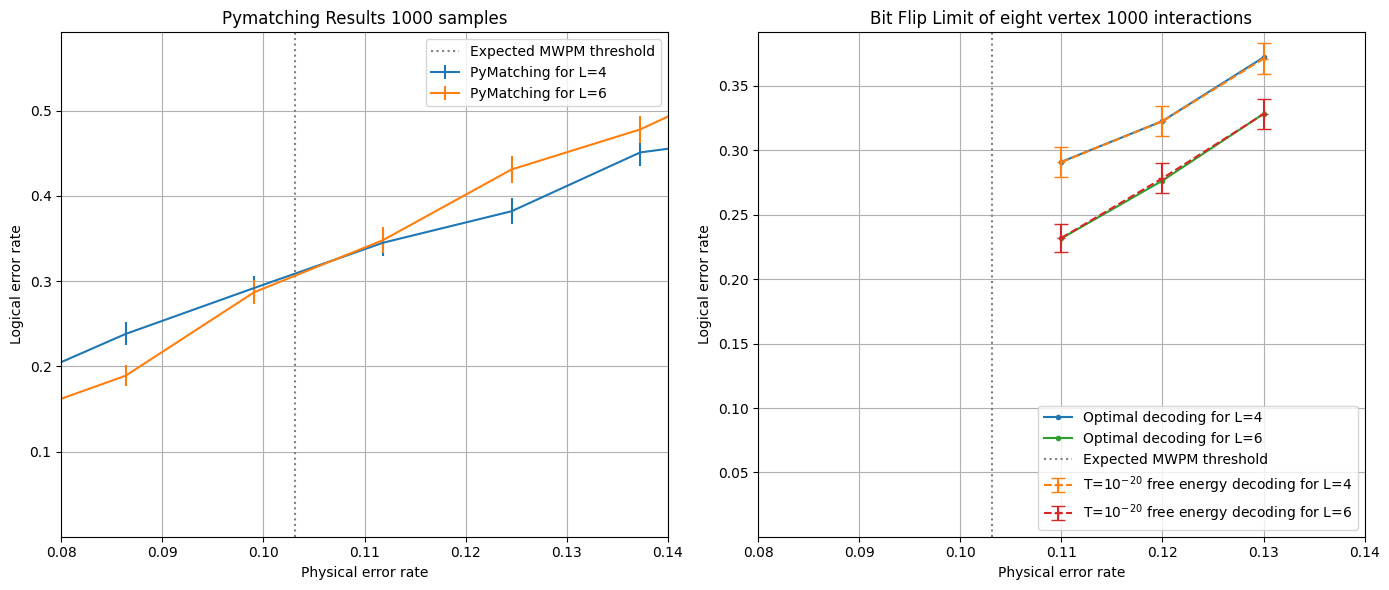

In [24]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Pymatching results on the first subplot
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors * (1 - logical_errors) / num_shots) ** 0.5
    ax1.errorbar(ps, logical_errors, yerr=std_err, label=f"PyMatching for L={L}")

ax1.axvline(x=0.1031, color="gray", label="Expected MWPM threshold", linestyle="dotted")
ax1.set_xlabel("Physical error rate")
ax1.set_ylabel("Logical error rate")
ax1.set_ylim(bottom=1e-4, top=None)
ax1.set_xlim(0.08, 0.14)
ax1.set_title("Pymatching Results 1000 samples")
ax1.legend()
ax1.grid(True)

# Plot the second loop results on the second subplot
for i, size in enumerate(sizes):
    ax2.plot(probabilities, [1 - optimal_curves[j][i] for j in range(len(probabilities))], ".-", label=f"Optimal decoding for L={size}")
    ax2.errorbar(probabilities, [1 - T0_curves[j][i] for j in range(len(probabilities))],
                 yerr=[[upper_bounds_T0[j][i] for j in range(len(probabilities))],
                       [lower_bounds_T0[j][i] for j in range(len(probabilities))]],
                 fmt='+--', label=f"T=$10^{{-20}}$ free energy decoding for L={size}", capsize=5)

ax2.axvline(x=0.1031, color="gray", label="Expected MWPM threshold", linestyle="dotted")
ax2.set_xlabel("Physical error rate")
ax2.set_ylabel("Logical error rate")
ax2.set_xlim(0.08, 0.14)
ax2.set_ylim(bottom=1e-4, top=None)
ax2.set_title("Bit Flip Limit of eight vertex 1000 interactions")
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()